# Podstawy sieci neuronowych, wykłady 7-10

# Wojciech Broniowski

## Instytut Fizyki, Uniwersytet Jana Kochanowskiego w Kielcach

# Inżynieria danych 2019/20

## Wersja z 5.05.2020

Link do vidyo: https://vidyoportal.cern.ch/join/o5nBkbwSf9

# Importowane pakiety

In [1]:
import math  as m
import numpy as np

# liczby losowe
import random

# grafika do wykresów
import matplotlib.pyplot as plt
import matplotlib as mpl

# działania na łańcuchach znaków
import string

# statystyka
import statistics as st

# pomar czasu
import time

# dopasowywanie krzywych do danych
from scipy.optimize import curve_fit

# wyświetlanie importowanej grafiki
from IPython.display import display, Image

# wykresy konturowe
import matplotlib.cm as cm

# dla wykresów trzywymiarowych
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Wykład 7/8

# Uczenie nienadzorowane

Omawiane we wcześniejszych wykładach uczenie nadzorowane potrzebuje nauczyciela, czy też próbki testowej, gdzie a priori znamy charakterystykę danych (w naszym przykładzie, punkt jest w kole lub poza nim). 
Dane szkoleniowe dla uczenia nadzorowanego dane muszą zatem zawierać "etykiety" (punkt w kole - 1, punkt poza kołem - 0). 

Jest to jednak sytuacja dość szczególna, bo częstokroć dane które napotykamy nie mają z góry przydzielonych etykiet i "są, jakie są", Również od strony biologicznej, czy też metodologicznej, wielu czynności uczymy się "na bieżąco", dokonujemy klasyfikacji i rozpoznawania, a wszystko toczy sie bez żadnego zewnetrznego nadzoru.

[botanik na łące]

Formalnie, problem uczenia nienadzorowanego wiąże się z klasyfikacją danych (podziałem na klastry, tj. skupiska, w których odległości między poszczególnymi danymi są małe, mniejsze niż odległości między klastrami). Jak już powiedziano, nie wiemy z góry, jakie te dane są, jakie mają ogólne charakterystyki ("etykiety"). Mówiąc potocznie, będziemy się doszukiwać podobieństw między poszczególnymi danymi.

## Przykład ze skupiskami (klastrami) punktów na płaszczyźnie

Zaczniemy od prostego przykładu ilustrującego podstawowe definicje i naturę problemu, który później będziemy rozwiązywać. 

Rozważmy punkty na płaszczyżnie, generowane losowo. Ich rozkład nie jest jednorodny, ale skupia się w czterech klastrach: A, B, C i D. Na przykład, możemy zadać odpowiednie granice dla współrzędnych $x_1$ i $x_2$ przy losowym generowaniu punktów danej kategorii. 

In [2]:
def pA():
    return [random.uniform(.75, .95),random.uniform(.7, .9)] 

def pB():
    return [random.uniform(.4, .6),random.uniform(.6, .75)] 
#    return [random.uniform(.55, .76),random.uniform(.5, .65)] 

def pC():
    return [random.uniform(.1, .3),random.uniform(.4, .5)] 

def pD():
    return [random.uniform(.7, .9),random.uniform(0, .2)] 

In [3]:
pB()

[0.5966018908988376, 0.7220418366712905]

Utwórzmy próbkę danych dla punktów z każdej kategorii:

In [4]:
samA=np.array([pA() for _ in range(10)])
samB=np.array([pB() for _ in range(7)])
samC=np.array([pC() for _ in range(9)])
samD=np.array([pD() for _ in range(11)])

In [5]:
col=['red','blue','green','magenta']

In [6]:
samA[:,1]

array([0.8035078 , 0.78196466, 0.82724227, 0.8626447 , 0.77986802,
       0.87354206, 0.83158711, 0.86870073, 0.84798764, 0.88123972])

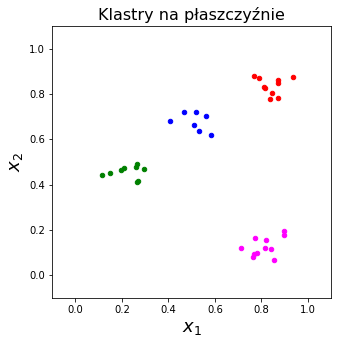

In [7]:
plt.figure(figsize=(5,5))
plt.title("Klastry na płaszczyźnie",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

plt.scatter(samA[:,0],samA[:,1],c=col[0], s=20)
plt.scatter(samB[:,0],samB[:,1],c=col[1], s=20)
plt.scatter(samC[:,0],samC[:,1],c=col[2], s=20)
plt.scatter(samD[:,0],samD[:,1],c=col[3], s=20)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Na oko widzimy, że klastry są dobrze zdefiniowane, tj. oodzielone od siebie. Możemy zatem reprezentować je **punktami reprezentatywnymi**, które leżą w obrębie klastra. Na przykład, dla każdego klastra bierzemy średnie położenie jego punktów jako punkt reprezentatywny:

In [8]:
rA=[st.mean(samA[:,0]),st.mean(samA[:,1])]
rB=[st.mean(samB[:,0]),st.mean(samB[:,1])]
rC=[st.mean(samC[:,0]),st.mean(samC[:,1])]
rD=[st.mean(samD[:,0]),st.mean(samD[:,1])]

In [9]:
rA

[0.842300793047345, 0.8358284718599395]

Możemy punkty charakterystyczne dodać do naszej grafiki:

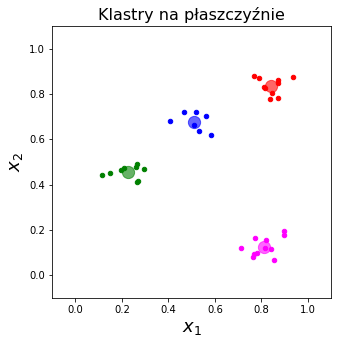

In [10]:
plt.figure(figsize=(5,5))
plt.title("Klastry na płaszczyźnie",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

plt.scatter(samA[:,0],samA[:,1],c=col[0], s=20)
plt.scatter(samB[:,0],samB[:,1],c=col[1], s=20)
plt.scatter(samC[:,0],samC[:,1],c=col[2], s=20)
plt.scatter(samD[:,0],samD[:,1],c=col[3], s=20)

plt.scatter(rA[0],rA[1],c=col[0], s=150, alpha=0.6)
plt.scatter(rB[0],rB[1],c=col[1], s=150, alpha=0.6)
plt.scatter(rC[0],rC[1],c=col[2], s=150, alpha=0.6)
plt.scatter(rD[0],rD[1],c=col[3], s=150, alpha=0.6)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Uwaga: Znalezienie punktów reprezentatywnych powyżej było proste, bo z góry znaliśmy rozkład próbki danych na klastry. W ogólnym problemie właśnie tego nie wiemy i jest to zadaniem do rozwiązania. Przystąpimy do tego później.

## Obszary Woronoja

Mając sytuację jak na powyższym rysunku, tj. określone punkty reprezentatywne, możemy podzielić całą płaszczyznę na obszary wg następującego kryterium:

Punkt P należy do kategorii reprezentowanej przez ten punkt reprezentatywny, który jest mu najbliższy.

Zdefiniujmy kolor punktu P na naszej płaszczyźnie jako kolor najblizszego punktu reprezentatywnego. W tym celu potrzebujemy najpierw funkcji odległości (tutaj: euklidesowej) między punktami (lub jej kwadratu):

In [11]:
def eucl(p1,p2): # kwadrat odległości euklidesowej
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2

Następnie znajdujemy najbliższy punkt reprezentatywny i określamy jego kolor:

In [12]:
def col_char(p):
    dist=[eucl(p,rA),eucl(p,rB),eucl(p,rC),eucl(p,rD)]
    ind_min = np.argmin(dist) # wskaźnik minimum listy odległości
    return col[ind_min]

In [13]:
np.linspace(0,1,70)

array([0.        , 0.01449275, 0.02898551, 0.04347826, 0.05797101,
       0.07246377, 0.08695652, 0.10144928, 0.11594203, 0.13043478,
       0.14492754, 0.15942029, 0.17391304, 0.1884058 , 0.20289855,
       0.2173913 , 0.23188406, 0.24637681, 0.26086957, 0.27536232,
       0.28985507, 0.30434783, 0.31884058, 0.33333333, 0.34782609,
       0.36231884, 0.37681159, 0.39130435, 0.4057971 , 0.42028986,
       0.43478261, 0.44927536, 0.46376812, 0.47826087, 0.49275362,
       0.50724638, 0.52173913, 0.53623188, 0.55072464, 0.56521739,
       0.57971014, 0.5942029 , 0.60869565, 0.62318841, 0.63768116,
       0.65217391, 0.66666667, 0.68115942, 0.69565217, 0.71014493,
       0.72463768, 0.73913043, 0.75362319, 0.76811594, 0.7826087 ,
       0.79710145, 0.8115942 , 0.82608696, 0.84057971, 0.85507246,
       0.86956522, 0.88405797, 0.89855072, 0.91304348, 0.92753623,
       0.94202899, 0.95652174, 0.97101449, 0.98550725, 1.        ])

In [14]:
# na przykład
col_char([.5,.5])

'blue'

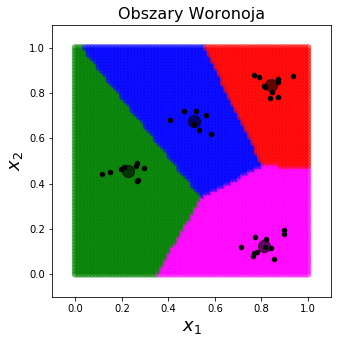

In [15]:
plt.figure(figsize=(5,5))
plt.title("Obszary Woronoja",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for x1 in np.linspace(0,1,70):
    for x2 in np.linspace(0,1,70):
        plt.scatter(x1,x2,c=col_char([x1,x2]), s=50, alpha=0.6, edgecolors='none')

plt.scatter(samA[:,0],samA[:,1],c='black', s=20)
plt.scatter(samB[:,0],samB[:,1],c='black', s=20)
plt.scatter(samC[:,0],samC[:,1],c='black', s=20)
plt.scatter(samD[:,0],samD[:,1],c='black', s=20)

plt.scatter(rA[0],rA[1],c='black', s=150, alpha=.6)
plt.scatter(rB[0],rB[1],c='black', s=150, alpha=.6)
plt.scatter(rC[0],rC[1],c='black', s=150, alpha=.6)
plt.scatter(rD[0],rD[1],c='black', s=150, alpha=.6)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

## Sformułowanie problemu podziału na klastry

A teraz nasz "prawdziwy" problem: wyobrażmy sobiem że mamy naszą próbkę, ale nic nie wiemy o tym, jak generowane były jej punkty (tzn. nie mamy żadnych "etykiet"). Nie mamy kolorów punktów, dane są zmieszane, tj. pojawiają się w losowej kolejności, co możemy uzyskać stosując np.random.shuffle:

In [16]:
alls=np.concatenate((samA, samB, samC, samD))
np.random.shuffle(alls)

Oto nasza próbka danych:

In [17]:
print(alls)

[[0.46926635 0.72238954]
 [0.26756173 0.41756131]
 [0.50969643 0.66100388]
 [0.76924497 0.09315698]
 [0.40862105 0.68221613]
 [0.78800222 0.86870073]
 [0.897164   0.17519917]
 [0.84798621 0.8035078 ]
 [0.26053711 0.47642587]
 [0.93448131 0.87354206]
 [0.11341544 0.44399955]
 [0.81745423 0.82724227]
 [0.19772874 0.46357516]
 [0.85263212 0.06592   ]
 [0.26517984 0.49147424]
 [0.5316406  0.6375395 ]
 [0.82112664 0.15498379]
 [0.29329508 0.46948443]
 [0.81472069 0.11862247]
 [0.20932533 0.47373578]
 [0.84157443 0.11541042]
 [0.89859289 0.19571728]
 [0.83759982 0.77986802]
 [0.51824192 0.72118671]
 [0.7116173  0.12051615]
 [0.76824572 0.88123972]
 [0.58359335 0.62022556]
 [0.77252215 0.16424532]
 [0.87200537 0.84798764]
 [0.87241274 0.78196466]
 [0.56322636 0.70234783]
 [0.26636907 0.41125614]
 [0.14772785 0.44961112]
 [0.78208113 0.09692055]
 [0.81303551 0.83158711]
 [0.76333415 0.07832217]
 [0.8717848  0.8626447 ]]


Wizualizacja danych wygląda zatem następująco:

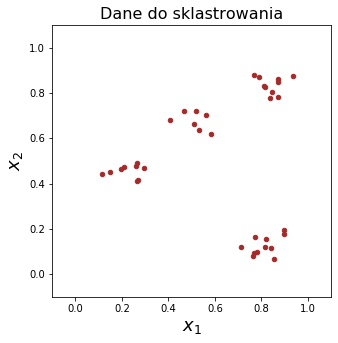

In [18]:
plt.figure(figsize=(5,5))
plt.title("Dane do sklastrowania",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Chcemy teraz w jakiś sposób utworzyć punkty reprezentatywne, ale a priori nie wiemy gdzie mają być, ani nawet ile ich jest. Są tu możliwe bardzo różne strategie. Ich wspólną cechą jest aktualizacja ich położenia w miarę "przetwarzania" danych z próbki. 

Spróbujmy zacząć od jednego punktu reprezentatywnego, którego położenie $(R_1,R_2)$ po wczytaniu kolejnego punktu danych P o współrzędnych $(x_1^P,x_2^P)$,zmienia się w następujący sposób:

$(R_1,R_2) \to (R_1,R_2) + \varepsilon (x_1^P-R_1,x_2^P-R_2)$,

lub w notacji wektorowej 

$\vec{R} \to \vec{R} + \varepsilon (\vec{x}-\vec{R})$,

gdzie, jak w poprzednich wykładach, $\varepsilon$ jest szybkością uczenia, która maleje 
w miarę wykonywania algorytmu. Powyższy wzór realizuje "przyciąganie" punktu R przez punkt danych P. 

In [19]:
np.random.shuffle(alls)
alls

array([[0.40862105, 0.68221613],
       [0.78208113, 0.09692055],
       [0.29329508, 0.46948443],
       [0.58359335, 0.62022556],
       [0.26756173, 0.41756131],
       [0.50969643, 0.66100388],
       [0.82112664, 0.15498379],
       [0.19772874, 0.46357516],
       [0.51824192, 0.72118671],
       [0.26053711, 0.47642587],
       [0.84798621, 0.8035078 ],
       [0.81472069, 0.11862247],
       [0.87241274, 0.78196466],
       [0.26636907, 0.41125614],
       [0.14772785, 0.44961112],
       [0.897164  , 0.17519917],
       [0.85263212, 0.06592   ],
       [0.46926635, 0.72238954],
       [0.76333415, 0.07832217],
       [0.20932533, 0.47373578],
       [0.5316406 , 0.6375395 ],
       [0.77252215, 0.16424532],
       [0.84157443, 0.11541042],
       [0.26517984, 0.49147424],
       [0.7116173 , 0.12051615],
       [0.81745423, 0.82724227],
       [0.81303551, 0.83158711],
       [0.56322636, 0.70234783],
       [0.11341544, 0.44399955],
       [0.83759982, 0.77986802],
       [0.

In [20]:
R=np.array([random.random(),random.random()])
print("Początkowy punkt reprezentatywny:")
print(R)
print("kolejne rundy")

Początkowy punkt reprezentatywny:
[0.11207703 0.52044207]
kolejne rundy


In [21]:
eps=.5

for _ in range(50):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        R+=eps*(alls[i]-R)
    print(R)   

[0.78892074 0.63637158]
[0.56231275 0.46979332]
[0.60407512 0.46624397]
[0.73095108 0.75921265]
[0.63560316 0.62443431]
[0.57179684 0.60623426]
[0.64269408 0.37383721]
[0.6936255  0.40885886]
[0.61237324 0.44193683]
[0.62328473 0.57763108]
[0.606806   0.50721614]
[0.58807332 0.4587522 ]
[0.60967354 0.49425412]
[0.63781961 0.48473727]
[0.60765213 0.51288221]
[0.6209845  0.51339537]
[0.62395147 0.49144652]
[0.60432268 0.5025137 ]
[0.61409952 0.49945562]
[0.62081936 0.51651448]
[0.62333338 0.5085739 ]
[0.6203728  0.50730566]
[0.62025583 0.50695414]
[0.62046045 0.50713776]
[0.61987916 0.50607991]
[0.62037636 0.50496533]
[0.62122884 0.50521225]
[0.62100715 0.50444845]
[0.62058476 0.50362457]
[0.62004906 0.50343286]
[0.62015794 0.50332799]
[0.62024536 0.50329468]
[0.62036963 0.50340677]
[0.62034165 0.50329188]
[0.62033691 0.50325996]
[0.62027337 0.5032069 ]
[0.62022369 0.50314566]
[0.62023941 0.50308934]
[0.62024428 0.50306443]
[0.62024198 0.50303136]
[0.62024166 0.50303067]
[0.62024519 0.50

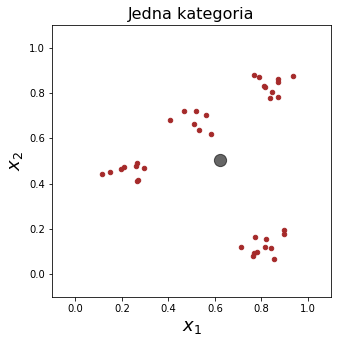

In [22]:
plt.figure(figsize=(5,5))
plt.title("Jedna kategoria",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

plt.scatter(R[0],R[1],c='black', s=150, alpha=.6)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

In [23]:
R_mean=[st.mean(alls[:,0]),st.mean(alls[:,1])]
R_mean

[0.6203525580655532, 0.5021981561856983]

Zauważmy, że punkt R przy tej procedurze dąży do średniego położenia danych. (Dodać komentarz o minimalizacji sumy odległosci i metody najstromszego spadku).

Spróbujmy uogólnić powyższy algorytm na przypadek kilku ($n_R>1$) punktów reprezetatywnych. 

- Inicjalizujemy losowo wektory reprezentatywne $R^i$, $i=1, ..., n_R$.

- Runda: Bierzemy w pętli po kolei punkty próbki i w danym kroku aktualizujemy jedynie punkt $R^m$ **najbliższy** punktowi P:

$\vec{R^m} \to \vec{R^m} + \varepsilon (\vec{x}-\vec{R^m})$.

- Położenie pozostałych punktów nie ulega zmianie. Taka strategia nazywa się "zwycięzca zabiera wszystko" (winner takes all)

- Możemy powtarzać rundy, zmniejszając za każdym razem szybkość uczenia $\varepsilon$.



Rozważmy zatem dwa punkty reprezentatywne, które inicjalizujemy losowo:

Klasyfikacja punktów próbki: należy do "klasy" najbliższego punktu reprezentatywnego.

In [24]:
R1=np.array([random.random(),random.random()])
R2=np.array([random.random(),random.random()])

print("Początkowe punkty reprezentatywne:")
print(R1, R2)
print("kolejne rundy")

Początkowe punkty reprezentatywne:
[0.32871418 0.64583622] [0.12470374 0.15627362]
kolejne rundy


In [25]:
eps=.5

for _ in range(50):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[eucl(p,R1),eucl(p,R2)] # kwadraty odległości
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        else:
            R2+=eps*(p-R2)            
    print(R1, R2)  

[0.25495138 0.44467937] [0.75902029 0.18426566]
[0.29703382 0.48594594] [0.82182497 0.13945751]
[0.47908246 0.63711374] [0.81390403 0.14420794]
[0.57083377 0.67938741] [0.84280756 0.15021788]
[0.53724945 0.66528702] [0.82039979 0.13816774]
[0.55776972 0.67044643] [0.82677009 0.12837521]
[0.51272825 0.64629718] [0.8175347  0.12028215]
[0.55497556 0.66415935] [0.80002524 0.11770188]
[0.58080387 0.67809918] [0.82018137 0.12817211]
[0.55509915 0.66162788] [0.81037345 0.12273864]
[0.55463426 0.66679357] [0.81284797 0.12172088]
[0.52946796 0.65589664] [0.8119596  0.12382889]
[0.56827241 0.67663465] [0.81079748 0.12282602]
[0.5380235 0.6616093] [0.81216526 0.12485888]
[0.5505611  0.66586115] [0.81300528 0.12548394]
[0.52502696 0.65428538] [0.81275676 0.12454661]
[0.52732681 0.65486417] [0.81153633 0.12431664]
[0.53419822 0.65940181] [0.81165567 0.12432008]
[0.53276076 0.65751477] [0.81189314 0.12451273]
[0.5368806  0.65916422] [0.81189623 0.12488663]
[0.53433933 0.65908342] [0.81178938 0.1251

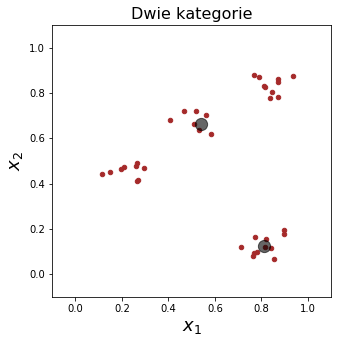

In [26]:

plt.figure(figsize=(5,5))
plt.title("Dwie kategorie",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

plt.scatter(R1[0],R1[1],c='black', s=150, alpha=.6)
plt.scatter(R2[0],R2[1],c='black', s=150, alpha=.6)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Teraz cztery punkty reprezentatywne:

Początkowe punkty reprezentatywne:
[0.61  0.583] [0.05  0.986] [0.957 0.948] [0.821 0.27 ]
kolejne rundy
[0.468 0.591] [0.05  0.986] [0.819 0.828] [0.803 0.123]
[0.224 0.485] [0.05  0.986] [0.76  0.813] [0.831 0.154]
[0.281 0.51 ] [0.05  0.986] [0.816 0.838] [0.845 0.148]
[0.265 0.522] [0.05  0.986] [0.808 0.805] [0.79  0.125]
[0.271 0.509] [0.05  0.986] [0.714 0.774] [0.81  0.137]
[0.307 0.531] [0.05  0.986] [0.818 0.809] [0.822 0.137]
[0.347 0.571] [0.05  0.986] [0.836 0.829] [0.805 0.116]
[0.328 0.514] [0.05  0.986] [0.851 0.832] [0.817 0.122]
[0.323 0.543] [0.05  0.986] [0.83  0.834] [0.812 0.127]
[0.347 0.558] [0.05  0.986] [0.837 0.835] [0.81  0.124]
[0.341 0.557] [0.05  0.986] [0.839 0.836] [0.807 0.122]
[0.351 0.563] [0.05  0.986] [0.841 0.837] [0.809 0.123]
[0.346 0.555] [0.05  0.986] [0.843 0.836] [0.808 0.124]
[0.359 0.563] [0.05  0.986] [0.843 0.836] [0.809 0.125]
[0.349 0.555] [0.05  0.986] [0.842 0.836] [0.81  0.125]
[0.353 0.556] [0.05  0.986] [0.842 0.836] [0.81  0.125]

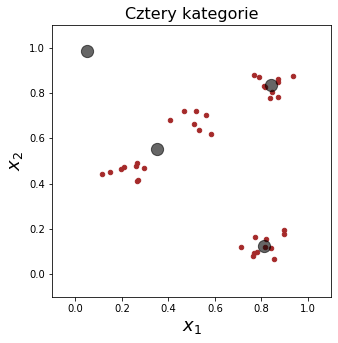

In [27]:
R1=np.array([random.random(),random.random()])
R2=np.array([random.random(),random.random()])
R3=np.array([random.random(),random.random()])
R4=np.array([random.random(),random.random()])


print("Początkowe punkty reprezentatywne:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   
print("kolejne rundy")

eps=.5

for _ in range(20):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[eucl(p,R1),eucl(p,R2),eucl(p,R3),eucl(p,R4)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        else:
            R4+=eps*(p-R4)             
    print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   

plt.figure(figsize=(5,5))
plt.title("Cztery kategorie",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

plt.scatter(R1[0],R1[1],c='black', s=150, alpha=.6)
plt.scatter(R2[0],R2[1],c='black', s=150, alpha=.6)
plt.scatter(R3[0],R3[1],c='black', s=150, alpha=.6)
plt.scatter(R4[0],R4[1],c='black', s=150, alpha=.6)


plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Puszczajac przypadek dla czterech kategorii zauważamy, że nie zawsze daje poprawną odpowiedź. Dość często jeden z punktów reprezentatywnych w ogóle nie jest uaktualniany (!), jest tzw. **trupem**. Dzieje się tak, ponieważ inne punkty reprezentatywne zawsze "wygrywają", któryś z nich jest zawsze bliżej każdego punktu próbki niż "trup".

Początkowe punkty reprezentatywne:
[0.839 0.215] [0.61  0.972] [0.389 0.325] [0.822 0.735] [0.143 0.15 ]
kolejne rundy
[0.83  0.141] [0.471 0.696] [0.245 0.445] [0.845 0.815] [0.143 0.15 ]
[0.816 0.142] [0.482 0.687] [0.214 0.455] [0.843 0.825] [0.143 0.15 ]
[0.782 0.11 ] [0.482 0.689] [0.237 0.452] [0.825 0.829] [0.143 0.15 ]
[0.831 0.127] [0.492 0.687] [0.242 0.446] [0.846 0.823] [0.143 0.15 ]
[0.796 0.133] [0.509 0.684] [0.212 0.448] [0.84 0.83] [0.143 0.15 ]
[0.798 0.11 ] [0.51  0.685] [0.229 0.454] [0.824 0.845] [0.143 0.15 ]
[0.805 0.121] [0.518 0.677] [0.231 0.453] [0.833 0.843] [0.143 0.15 ]
[0.802 0.118] [0.511 0.679] [0.226 0.455] [0.847 0.843] [0.143 0.15 ]
[0.806 0.124] [0.516 0.675] [0.217 0.455] [0.841 0.837] [0.143 0.15 ]
[0.815 0.127] [0.515 0.679] [0.22  0.455] [0.837 0.836] [0.143 0.15 ]
[0.81  0.125] [0.515 0.678] [0.222 0.455] [0.841 0.837] [0.143 0.15 ]
[0.814 0.127] [0.514 0.678] [0.218 0.456] [0.839 0.838] [0.143 0.15 ]
[0.814 0.128] [0.513 0.678] [0.222 0.456] [

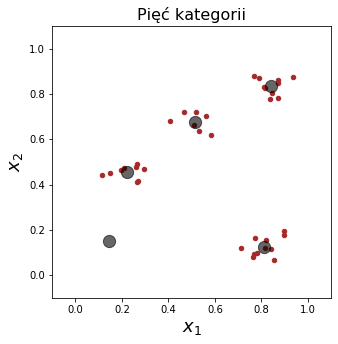

In [28]:
R1=np.array([random.random(),random.random()])
R2=np.array([random.random(),random.random()])
R3=np.array([random.random(),random.random()])
R4=np.array([random.random(),random.random()])
R5=np.array([random.random(),random.random()])

print("Początkowe punkty reprezentatywne:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3), np.round(R5,3))   
print("kolejne rundy")

eps=.5

for _ in range(20):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[eucl(p,R1),eucl(p,R2),eucl(p,R3),eucl(p,R4),eucl(p,R5)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        elif ind_min==3:
            R4+=eps*(p-R4)  
        else:
            R5+=eps*(p-R5)             
    print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3), np.round(R5,3))   

plt.figure(figsize=(5,5))
plt.title("Pięć kategorii",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

plt.scatter(R1[0],R1[1],c='black', s=150, alpha=.6)
plt.scatter(R2[0],R2[1],c='black', s=150, alpha=.6)
plt.scatter(R3[0],R3[1],c='black', s=150, alpha=.6)
plt.scatter(R4[0],R4[1],c='black', s=150, alpha=.6)
plt.scatter(R5[0],R5[1],c='black', s=150, alpha=.6)

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Działanie dla pięciu punktów reprezentatywnych prowadzi znacznie częściej do powstawania "trupów". Natomiast rzadko powstaje sytuacja, gdy jeden z klastrów jest dodatkowo dzielony na mniejsze (są w nim blisko siebie dwa punkty reprezentatywne).

**Powtarzaj wykonanie powyższej komórki.**

## Strategia rozszczepiania

Aby uniknąć załamywania się algorytmu wskutek powstawania "trupów" można stosować różne strategie. Jedną z nich jest umieszczenie początkowych punktów reprezentatywnych blisko średniego położenia punktów próbki. W tym przypadku losujemy ich niewielkie odchylenie od średniej i dalej realizujemy algorytm jak uprzednio.

Można ten przepis przedstawić w następujący sposób: najpierw wykonujemy algorytm dla jednego punktu reprezentatywnego, znajdując w ten sposób przybliżone średne położenie punktów próbki. Następnie "rozszczepiamy" nasz punkt reprezentatywny na wiecej punktów ($n$), delikatnie je losowo rozrzucamy, po czym realizujemy algorytm dla tychże $n$ punktów reprezentatywnych.

Inne modyfikacje w tym duchu mogą rozszczepiać punkty charakterystyczne wielokrotnie, np. najpierw jeden na dwa, potem te dwa na kolejne itd. Analogia do systematyki podziałów.

In [29]:
def rp(): # liczba losowa z przedziału [-0.05,0.05]
    return np.array([random.random()-0/5,random.random()-0.5])/10

In [30]:
rp()

array([ 0.07935897, -0.00957546])

In [31]:
R1=R_mean+rp()
R2=R_mean+rp()
R3=R_mean+rp()
R4=R_mean+rp()


print("Początkowe punkty reprezentatywne:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   
print("kolejne rundy")

Początkowe punkty reprezentatywne:
[0.66  0.512] [0.715 0.548] [0.717 0.517] [0.717 0.473]
kolejne rundy


In [32]:
eps=.5

for _ in range(10):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[eucl(p,R1),eucl(p,R2),eucl(p,R3),eucl(p,R4)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        else:
            R4+=eps*(p-R4)             
    print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   

[0.198 0.458] [0.835 0.814] [0.504 0.684] [0.817 0.129]
[0.22  0.445] [0.806 0.849] [0.515 0.699] [0.819 0.142]
[0.238 0.467] [0.857 0.848] [0.512 0.671] [0.837 0.129]
[0.222 0.453] [0.83 0.83] [0.504 0.687] [0.795 0.117]
[0.236 0.448] [0.84  0.839] [0.511 0.685] [0.805 0.122]
[0.228 0.455] [0.828 0.841] [0.506 0.679] [0.811 0.124]
[0.231 0.461] [0.835 0.826] [0.509 0.68 ] [0.806 0.126]
[0.228 0.456] [0.843 0.826] [0.51  0.682] [0.817 0.133]
[0.233 0.458] [0.836 0.832] [0.513 0.677] [0.824 0.135]
[0.23  0.458] [0.833 0.837] [0.511 0.676] [0.809 0.125]


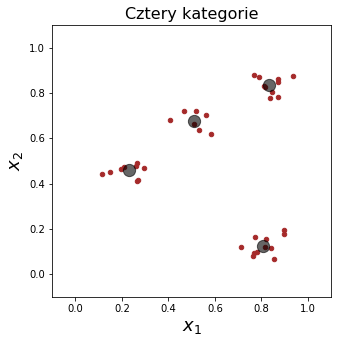

In [33]:
plt.figure(figsize=(5,5))
plt.title("Cztery kategorie",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

plt.scatter(R1[0],R1[1],c='black', s=150, alpha=.6)
plt.scatter(R2[0],R2[1],c='black', s=150, alpha=.6)
plt.scatter(R3[0],R3[1],c='black', s=150, alpha=.6)
plt.scatter(R4[0],R4[1],c='black', s=150, alpha=.6)


plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

## Skala klastrowania

Omówione powyżej przykłady dały nam pewną intuicję dot. uczenia nienadzorowanego w dzieleniu próbki danych **bez etykiet** na klastry, tj. na skupiska podobnych "osobników". Przy bliższym zastanowieniu się, problem pozostaje jednak niedodefiniowany w niekomfortowy sposób. Po pierwsze, ... Kwestia skali

liczba punktów reprezentatywnych:  4


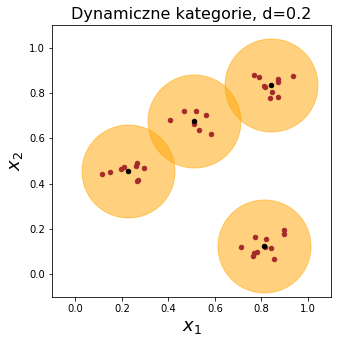

In [34]:
# NIE MA na razie żadnego punktu reprezentatywnego

d=0.2 # skala klastra
eps=.5 

for r in range(25): # rundy
    eps=0.85*eps
    np.random.shuffle(alls) 
    if r==0:                 # przy początkowej rundzie
        R=np.array([alls[0]])
#        print(R)       
    for i in range(len(alls)): # po punktach próbki
        p=alls[i]
        dist=[eucl(p,R[k]) for k in range(len(R))] # kwadraty odległości od obecnych punktów 
                                                   # reprezentatywnych
#        print(dist)
        ind_min = np.argmin(dist)
        if dist[ind_min] > d*d:     # jeśli odległość > d
#            print("-> nowy punkt reprezentatywny")
            R=np.append(R, [p], axis=0)
        else:   
            R[ind_min]+=eps*(p-R[ind_min])

print("liczba punktów reprezentatywnych: ",len(R))
 
plt.figure(figsize=(5,5))
plt.title("Dynamiczne kategorie, d="+str(d),fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='orange', s=(465*d)**2, alpha=.5)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20)


plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);    

## Interpretacja algorytmu jako metody najstromszego spadku

Oznaczmy dany klaster symbolem $C_i$, $i=1,...,n$, gdzie $n$ jest liczbą klastrów. Suma kwadratów odległości punktów danych z klastra $C_i$ do jego puntu reprezentatywnego $R^i$ wynosi 

$\sum_{P \in C_i}|\vec{R}^i-\vec{x}^P|^2$.

Sumując po wszystkich klastrach otrzymujemy funkcję analogiczną do wcześniej dyskutowanej funkcji błędu:

$B(\{R\}) = \sum_{i=1}^n \sum_{P \in C_i}|\vec{R}^i-\vec{x}^P|^2$.

Jej pochodna po położeniu wektora $R_i$ to

$\partial B(\{R\})/\partial \vec{R}^i 
= 2 \sum_{P \in C_i}(\vec{R}^i-\vec{x}^P)$.

Metoda najstromszego spadku daje zatem **dokładnie** przepis uaktualniania stosowany powyżej, tj.

$\vec{R} \to \vec{R} - \varepsilon (\vec{R}-\vec{x^P})$.

Podsumowując, stosowany wcześniej algorytm zawiera dyskutowaną w poprzednich wykładach metodę najstromszego spadku dla funkcji $B(\{R\})$. Zauważmy jednak, że minimalizacja stosowana w naszych algorytmach uwzglednia również podział punktów na klastry, tzn. dany punkt danych może w trakcie algorytmu zmienić swój klaster. Staje się tak, gdy ulega zmianie najbliższy mu punkt charakterystyczny. 

### Inna funkcja błędu

Użyta dotychczas funkcja błędu sumuje **kwadraty** odległości punktów danych od (najbliższych im) punktów charakterystycznych. Powstaje pytanie, co by się stało, gdybyśmy użyli samych odległości, a nie ich kwadratów. Wówczas

$B(\{R\}) = \sum_{i=1}^n \sum_{P \in C_i}\sqrt{|\vec{R}^i-\vec{x}^P|^2}$.

a pochodna po położeniu wektora $R_i$ wynosi

$\partial B(\{R\})/\partial \vec{R}^i 
= \sum_{P \in C_i}\frac{\vec{R}^i-\vec{x}^P}{\sqrt{|\vec{R}^i-\vec{x}^P|^2}}$.

Metoda najstromszego spadku daje teraz przepis uaktualniania postaci

$\vec{R} \to \vec{R} - \varepsilon \frac{\vec{R}-\vec{x^P}}{\sqrt{|\vec{R}^i-\vec{x}^P|^2}}$.

Celem uniknięcia dzielenia przez zero gdy punkt danych pokrywa się z punktem charakterystycznym, używa się typowej sztuczki z wprowadzeniem małej liczny buforującej 
$\delta$ do mianownika:

$\vec{R} \to \vec{R} - \varepsilon \frac{\vec{R}-\vec{x^P}}{\sqrt{|\vec{R}^i-\vec{x}^P|^2+\delta^2}}$.

Zobaczmy, jak działa zmodyfikowany algorytm:

liczba punktów reprezentatywnych:  12


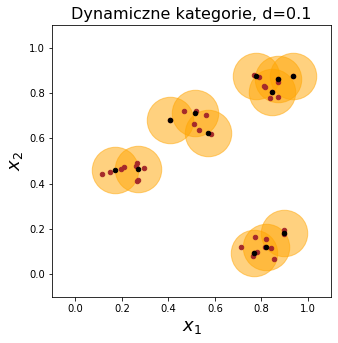

In [35]:
d=0.1
eps=.05
delta=.001

for r in range(25):
    eps=0.85*eps
    np.random.shuffle(alls)
    if r==0:
        R=np.array([alls[0]])
#        print(R)       
    for i in range(len(alls)):
        p=alls[i]
        dist=[eucl(p,R[k]) for k in range(len(R))]
#        print(dist)
        ind_min = np.argmin(dist)
        if dist[ind_min] > d*d:
#            print("-> nowy punkt reprezentatywny")
            R=np.append(R, [p], axis=0)
        else:   
            R[ind_min]+=eps*(p-R[ind_min])/np.sqrt(dist[ind_min]+delta*delta)

print("liczba punktów reprezentatywnych: ",len(R))
 
plt.figure(figsize=(5,5))
plt.title("Dynamiczne kategorie, d="+str(d),fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='orange', s=(465*d)**2, alpha=.5)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20)


plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);    

Porównując z poprzednim wykresem widzimy, że wynik jest bardzo podobny, ale nie identyczny. 

# ZADANIA

1. Weź metrykę miejską zamiast euklidesowej,

$d(\vec{x},\vec{y})=|x_1-y_1|+|x_2 - y_2|$ dla punktów $\vec{x}$ i $\vec{y}$,

i powtórz konstrukcję obszarów Woronoja dla tej metryki.
Powtórz pozostałe części wykładu z tą metryką. 

2. Powtórz różne warianty algorytmów klasyfikacji dla większej liczby kategorii w próbce danych. Przydyskutuj działanie algorytmów (dla metryki euklidesowej lub miejskiej, do wyboru).

# WYKŁAD 9

## Interpretacja w ramach sieci neuronowych

Spróbujemy teraz zinterpretować powyższy algorytm uczenia nienadzorowanego ze strategią "zwycięzca bierze wszystko" w języku sieci neuronowych. Weźmiemy dla ilustracji naszą sieć z czterema punktami reprezentatywnymi.

In [36]:
def plot_net_lab_0(n_war, wagi, x):
    """Narysuj sieć z etykietami"""
    li_war=len(n_war)
    plt.figure(figsize=(9,5)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            lab=x[i][j]
            plt.text(i+0.1, j-n_war[i]/2+0.1, lab, fontsize=16)
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]):
                plt.plot([i,i+1],[j-n_war[i]/2,k-n_war[i+1]/2],c='gray',linewidth=0.4)
                plt.text(i+0.75, 0.25*(j-n_war[i]/2)+0.75*(k-n_war[i+1]/2), 
                         wagi[i+1][j][k], fontsize=16)

    plt.axis("off")
    plt.show()

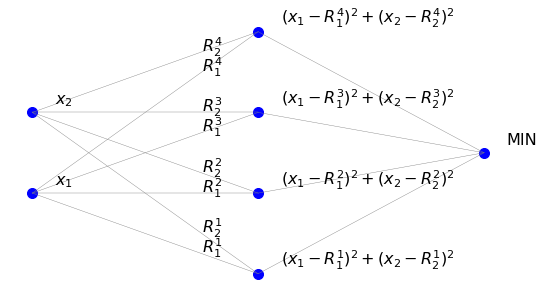

In [37]:
plot_net_lab_0([2,4,1],
             {1: [["$R_1^1$", "$R_1^2$", "$R_1^3$", "$R_1^4$"], 
                  ["$R_2^1$", "$R_2^2$", "$R_2^3$", "$R_2^4$"]], 
              2: [[""], [""], [""],[""]]} ,
             {0: np.array(["$x_1$","$x_2$"]), 
              1: np.array(["$(x_1-R_1^1)^2+(x_2-R_2^1)^2$",
                           "$(x_1-R_1^2)^2+(x_2-R_2^2)^2$",
                           "$(x_1-R_1^3)^2+(x_2-R_2^3)^2$", 
                           "$(x_1-R_1^4)^2+(x_2-R_2^4)^2$"]), 
              2: np.array(["MIN"])})

Są tu pewne istotne różnice w stosunku do omawianego wcześniej perceptronu. 

- Nie ma wierzchołków progowych.

- W warstwie pośredniej (nieliniowy) sygnał jest kwadratem odległości, a nie sumą ważoną.

- Węzeł w ostatniej warstwie (MIN) wskazuje, w którym neuronie warstwy pośredniej sygnał jest najmniejszy, tj. mamy najmniejszą odległość (strategia "zwycięzca bierze wszystko").

Zastosowanie powyższej sieci klasyfikuje punkt o współrzędnych $(x_1, x_2)$, przydzielając mu numer punktu reprezentatywnego danej kategorii (tutaj jest to liczba 1, 2, 3 lub 4).  

## Interpretacja z pomocą współrzędnych sferycznych

Użycie powyżej **nieliniowego** sygnału kontrastuje z przyjętą w perceptronie zasadą, że sygnał wchodzący do neuronu $i$ jest ważoną sumą inputów, tj.

$s^i=x_1 w_1^i + x_2 w_2^i+...+ w_1^m x_m = \vec{x} \cdot \vec{w}^i$.

Możemy zastosować pewną prostą konstrukcję geometryczną aby upodobnić obecną sieć do zasady perceptronu. W tym celu (dla naszego przykładu o inpucie z przestrzeni dwuwymiarowej, 
$0 \le x_{1,2} \le 1$) wprowadzamy dodatkową trzecią współrzędną jako 

$x_3=\sqrt{r^2-x_1^2-x_2^2}$, 

gdzie $r$ jest stałą dobraną tak, aby dla wszystkich punktów danych $r^2 \ge x_1^2+x_2^2$
Z konstrukcji $\vec{x} \cdot \vec{x}=x_1^2+x_2^2+x_3^2=r^2$, zatem punkty danych leżą na półsferze ($x_3\ge 0$) o promieniu $r$. Podobnie postępujemy dla punktów reprezentatywnych:

$w_1^i = R_1^i$,  $\; w_2^i = R_2^i$,  $\; w_3^i=\sqrt{r^2-R_1^{i2}-R_2^{i2}}$.

Jest geometrycznie oczywiste, że dwa punkty są sobie bliskie na płaszczyźnie wtedy i tylko wtedy, gdy ich opisane powyżej rozszerzenia do półsfery są sobie bliskie. Poprzemy tę uwagę prostym rachunkiem:

Iloczyn skalarny dwóch punktów $\vec{x}$ i $\vec{y}$ na półsferze możemy zapisać jako

$\vec{x} \cdot \vec{y} = x_1 y_1 + x_2 y_2 + \sqrt{r^2-x_1^2-x_2^2}\sqrt{r^2-y_1^2-y_2^2}$.

Rozważmy dla prostoty sytuację, gdy $x_1^2+x_2^2 \ll r^2$ oraz $y_1^2+y_2^2 \ll r^2$, tj. obydwa punkty leżą w pobliżu bieguna półsfery. Stosując znane Ci z analizy matematycznej rozwinięcie 

$\sqrt{r^2-a^2} \simeq r - \frac{a^2}{2r}$,  $\;\;\;a \ll r$, 

otrzymujemy 

$\vec{x} \cdot \vec{y} \simeq x_1 y_1 + x_2 y_2 + \left( r -\frac{x_1^2+x_2^2}{2r} \right) \left( r -\frac{y_1^2+y_2^2}{2r} \right) \\ 
\;\;\;\simeq r^2 - \frac{1}{2} (x_1^2+x_2^2 +y_1^2+y_2^2) + x_1 y_1+x_2 y_2 \\ 
\;\;\; = r^2 - \frac{1}{2}[ (x_1-x_2)^2 +(y_1-y_2)^2]$.

Jest to zatem (dla punktów bliskich biegunowi) stała $r^2$ minus połowa kwadratu odległości miedzy punktami $(x_1,x_2)$ i $(y_1,y_2)$ na płaszczyźnie! Wynika stąd, że zamiast znajdować minimalne odległości dla punktów na płaszczyźnie, jak w powyższych algorytmach, możemy znajdować maksymalne iloczyny skalarne dla ich rozszerzeń do półsfery. 

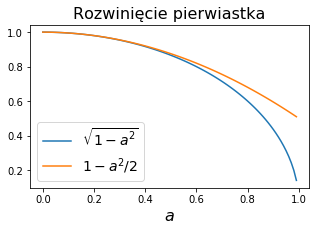

In [38]:
plt.figure(figsize=(5,3))
plt.title("Rozwinięcie pierwiastka",fontsize=16) 

s=np.arange(0,1,.01)
st=np.sqrt(1-s**2)
se=1-s**2/2

plt.plot(s,st)
plt.plot(s,se)

plt.legend(('$\sqrt{1-a^2}$','$1-a^2/2$'),fontsize=14)
plt.xlabel('$a$',fontsize=16);

W wariancie rozszerzenia danych do półsfery, odpowiednią sieć neuronową możemy przedstawić następująco:

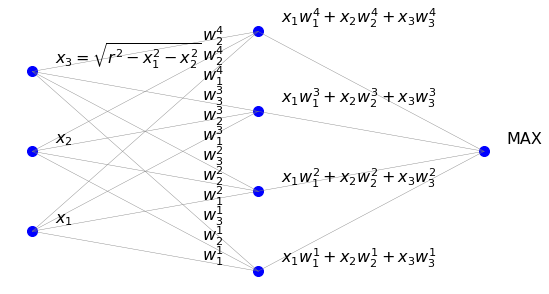

In [39]:
plot_net_lab_0([3,4,1],
             {1: [["$w_1^1$", "$w_1^2$", "$w_1^3$", "$w_1^4$"], 
                  ["$w_2^1$", "$w_2^2$", "$w_2^3$", "$w_2^4$"],
                  ["$w_3^1$", "$w_3^2$", "$w_3^3$", "$w_2^4$"]], 
              2: [[""], [""], [""],[""]]} ,
             {0: np.array(["$x_1$","$x_2$","$x_3=\sqrt{r^2-x_1^2-x_2^2}$"]), 
              1: np.array(["$x_1 w_1^1+x_2 w_2^1+x_3 w_3^1$",
                           "$x_1 w_1^2+x_2 w_2^2+x_3 w_3^2$",
                           "$x_1 w_1^3+x_2 w_2^3+x_3 w_3^3$", 
                           "$x_1 w_1^4+x_2 w_2^4+x_3 w_3^4$"]), 
              2: np.array(["MAX"])})

Widzimy, że dzięki naszym zabiegom sygnał w warstwie pośredniej jest liniowy. Neuron w ostatniej warstwie (MAX) wskazuje, gdzie iloczyn skalarny jest największy.

## Algorytm uczenia nienadzorowanego oparty o maksymalizację iloczynu skalarnego

Algorytm jest teraz następujący:

- Rozszerz punkty z próbki o trzecią współrzędna, $x_3=\sqrt{r^2-x_1^2-x_2^2}$, dobierając odpowiednio duże $r$, aby $r^2>x_1^2+x_2^2$ dla wszystkich punktów próbki.

- Zainicjalizuj wagi w taki sposób, by $\vec{w}_i \cdot \vec{w}_i=r^2$.

Nastepnie w pętli po punktach 

- Znajdź neuron w warstwie pośredniej, dla którego iloczyn skalarny $x \cdot \vec{w}_i$ jest największy. Zmień wagi tego neuronu wg przepisu

$\vec{w}^i \to \vec{w}^i + \varepsilon (\vec{x}-\vec{w}^i)$.

- Znormalizuj zaktualizowany wektor wagowy $\vec{w_i}$, aby $\vec{w}_i \cdot \vec{w}_i=r^2$:

$\vec{w}^i \to \vec{w}^i \frac{r}{\sqrt{\vec{w}_i \cdot \vec{w}_i}}$.

Pozostałe elementy algorytmu, jak ustalanie początkowych położeń punktów reprezentatywnych, ich ew. rozszczepianie czy dynamiczne tworzenie w miarę napotykania kolejnych punktów danych, pozostają jak w uprzednio omówionych procedurach.

Uogólnienie dla $n$ wymiarów jest oczywiste: wprowadzamy dodatkową współrzędną 

$x_{n+1}=\sqrt{r^2 - x_1^2-...-x_n^2}$, 

zatem mamy punkt na hipersferze $x_1^2+...+x_n^2+x_{n+1}^2=r^2$.

In [40]:
v=np.array([1,2,3])
norm=np.dot(v,v)
np.sqrt(norm)
v=v/np.sqrt(norm)
v
np.dot(v,v)

1.0

### Poprzedni przykład w obecnym wariancie

liczba punktów reprezentatywnych:  4


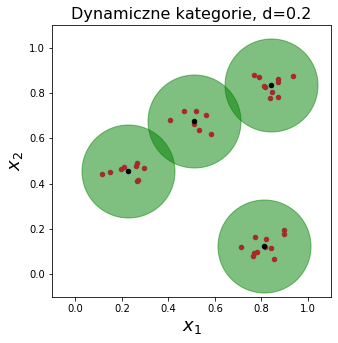

In [41]:
d=0.2
eps=.5

rad=2 # promień sfery r

for r in range(25):
    eps=0.85*eps
    np.random.shuffle(alls)
    if r==0:
        p=alls[0]
        R=np.array([np.array([p[0],p[1],np.sqrt(rad**2 - p[0]**2 - p[1]**2)])])
    for i in range(len(alls)):
        p=np.array([alls[i][0], alls[i][1], np.sqrt(rad**2 - alls[i][0]**2 - alls[i][1]**2)])
          # rozszerzenie do półsfery
        dist=[np.dot(p,R[k]) for k in range(len(R))] # iloczyny skalarne
        ind_max = np.argmax(dist)                    # położenie maksimum
        if dist[ind_max] < rad**2 - d**2/2:
            # warunek, że iloczyn skalarny jest mniejszy od r^2-d^2/2 jest 
            # dla małych d równoważny warunkowi, że kwadrat odległości 
            # w dwóch wymiarach jest wiekszy od d
            R=np.append(R, [p], axis=0)
        else:   
            R[ind_max]+=eps*(p-R[ind_max])

print("liczba punktów reprezentatywnych: ",len(R))
 
plt.figure(figsize=(5,5))
plt.title("Dynamiczne kategorie, d="+str(d),fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='green', s=(465*d)**2, alpha=.5)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=20)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20)


plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);    

Widzimy, że działanie algorytmu z maksymalizacją iloczynu skalarnego jest niemal dokładnie takie samo, jak dla minimalizacji kwadratów odległości w poprzednim wykładzie.

## Reguła Hebba

[Wikipedia]  Hebb's rule:

"Let us assume that the persistence or repetition of a reverberatory activity (or "trace") tends to induce lasting cellular changes that add to its stability. ... When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A's efficiency, as one of the cells firing B, is increased."
    
W naszym sformułowaniu, jeśli sygnał przechodzi przez dane połączenie, to jego waga się odpowiednio zmienia, a pozostałe połączenia nie ulegają zmianie. Proces zachodzi w sposób nienadzorowany, a jego realizacja jest biologicznie dobrze umotywowana. Połączenia synaptyczne mogą się bowiem wzmacniać lub osłabiać. 

Natomiast trudno jest znależć uzasadnienie biologiczne dla propagacji wstecznej w uczeniu nadzorowanym, gdzie uaktulniane są wszystkie wagi, także w bardzo odległych od outputu warstwach. Wg wielu badaczy, jest to raczej koncepcja matematyczna, niemniej niesłychanie użyteczna. 

## Zadanie (nieobowiązkowe):

Rozważ problem klastrowania punktów o różnych skalach szarości. W tym celu wprowadź skalę szarości jako liczbę $s$ z przedziału $[0,1]$ i wektor danych postaci 
$(s,\sqrt{1-s^2})$, który jest znormalizowany do 1 (takie punkty leżą na półkolu). Wygeneruj kilka klastrów tych punktów. Wprowadź wektory wagowe i wyucz je w nienadzorowany sposób na Twojej próbce strategią "zwycięzca bierze wszystko". 

# WYKŁAD 10

# Sieci Kohonena (Self Organizing Maps)



Innym bardzo ważnym zastosowaniem uczenia nienadzorowanego są tzw. **sieci Kohonena** (fiński neurobiolog Teuvo Kohonen, 1970'), tj. **samoorganizujące się odwzorowania zachowujace topologię**. Rozważmy odwzorowanie

$N \to D=f(N)$,

gdzie $D$ jest zbiorem danych inputowych, a $N$ jest zbiorem  dyskretnym neuronów. Ogólnie, wymiary tych zbiorów mogą być dowolne. Odwzorowanie $f$
ma następującą **topologiczną** własność: jeśli dwa neurony $n_1$ i $n_2$ z są sobie bliskie, to również $d_1=f(d_1)$ i $d_2=f(n_2)$ są sobie bliskie. Pozwala to na "przeniesienie" struktur z przestrzeni danych $D$ do przestrzeni neuronów $N$. 

Taki mechanizm zachodzi np. w układzie wzrokowym, o czym niebawem.

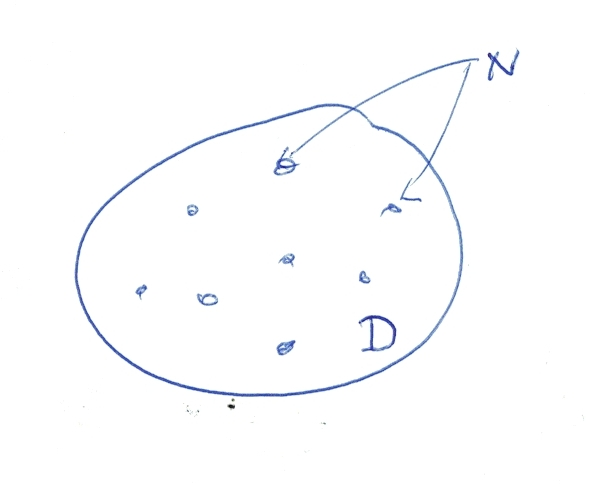

In [42]:
Image(filename="images/ND.jpg",width=400)

## Algorytm Kohonena i strategia "zwycięzca bierze większość"

Niech $D$ będzie $n$-wymiarowym zbiorem danych, a $N$ dyskretnym zbiorem neuronów. 
Wskaźnik neuronu, składający się z $k$ liczb naturalnych, 
jest oznaczony jako $\bar{i}=(i_1, i_2, ..., i_k)$ ($k$ jest zatem dyskretnym wymiarem zbioru $N$). 

Rozważa się sytuacje, dla których $n \ge k$, tj. **redukcję liczby wymiarów** z przestrzeni danych $D$ do przetrzeni $N$. 


Całkowita liczba 
neuronów oznaczona jest jako $m$.

Określamy też funkcję sprzężenia sąsiadów w zbiorze $N$, zależną od ich względnego położenia, $\phi(\bar{i}, \bar{j})$. Funkcja ta musi maleć z odległością między wskaźnikami. Typowy wybór to funkcja Gaussa:

$\phi(\bar{i}, \bar{j})=\exp\left [ -\frac{(i_1-j_1)^2+...+(i_k-j_k)^2}{2 \delta^2} \right ]$,

gdzie $\delta$ jest **promieniem sąsiedztwa**.

**Algorytm**

0. Inicjalizujemy losowo $k$-wymiarowe wagi $w_i$ dla wszystkich $m$ neuronów. Ustalamy początkowy promień sąsiedztwa $\delta$ i szybkość uczenia $\varepsilon$.

1. Wybieramy (losowo) punkt danych $x$ z przestrzeni inputowej (ew. z odpowiednim rozkładem prawdopodobieństwa).

2. Znajdujemy neuron $\bar{l}$, dla którego odległość od $x$ jest najmniejsza.

3. Wagi są uaktualniane wg przepisu

$w_{\bar{i}} \to w_{\bar{i}} + \varepsilon \phi(\bar{i}, \bar{l})(x - w_{\bar{i}})$,  $\;\;\; i = 1, . . . , m$.

4. Powtarzamy od kroku 1 aż do uzyskania zadowalającego wyniku, **zmniejszając** odpowiednio 
parametry $\varepsilon$ i $\delta$. To zmniejszanie i sposób, w jaki jest robione, jest istotne dla poprawnego działania algorytmu. Jako kryterium zakończenia stosuje się ograniczenie na liczbę iteracji lub na wielkość zmiany wag. Np. jeśli wagi zmieniaja się mniej niż pewna mała liczba, to przerywamy.

Zauważmy, że uaktualnianie w punkcie 3 jest strategią **"zwyciężca bierze większość"** (winner takes most"). Okazuje się, że uaktualnianie sąsiadów jest kluczowe dla zachowania topologii - bliskie neurony z dużym prawdopodobieństwem też odpalają. Im dalsze jest $i$ od zwycięzcy $l$, tym słabiej uaktualniany jest neuron $i$.

Mówiąc obrazowo, punkt $x$ przyciąga najbliższy mu neuron oraz (słabiej) jego sąsiedztwo. Po wieu krokach nauki poszczególne neurony "specjalizują się" (sa bliskie) w pewnym obszarze danych. Niterywialne jest, ze zachowana jest wymieniona powyżej własność topologiczna. 

Zobaczmy, jak procedura działa na prostym przykładzie:

## Przykład odwzorowania danych dwuwymiarowych na jednowymiarową sieć neuronów

Wczytaj jedną komórkę poniżej

In [43]:
def point(): # punkt z dwuwymiarowego kwadratu [0,1]x[0,1]
    return np.array([random.random(),random.random()])

In [44]:
def point(): # inny obszar: koło
    while True:
        x=random.random()
        y=random.random()
        if (x-0.5)**2+(y-0.5)**2 < 0.4**2:
            break
    return np.array([x,y])

In [45]:
point()

array([0.73981344, 0.81489955])

In [46]:
num=100 # liczba neuronów (jeden wskaźnik)

In [47]:
def phi(i,k,d): # funkcja sprzężenia sąsiadów
    # i oraz k są (jednowymiarowymi) wskaźnikami neuronów
    # d jest charakterystyczną skalą (szerokością funkcji Gaussa) 
    return np.exp(-(i-k)**2/(2*d**2))

In [48]:
np.round(phi(10,13,2),3)

0.325

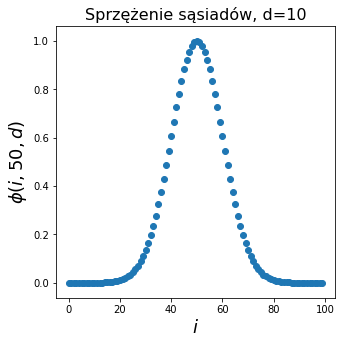

In [49]:
l=50
d=10

plt.figure(figsize=(5,5))
plt.title("Sprzężenie sąsiadów, d="+str(d),fontsize=16) 

ind=[i for i in range(num)]
ph= [phi(i,l,d) for i in range(num)]

plt.scatter(ind,ph)

plt.xlabel('$i$',fontsize=18)
plt.ylabel('$\phi(i,$'+str(l)+'$,d)$',fontsize=18);    

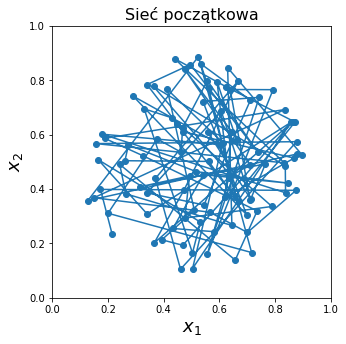

In [50]:
W=np.array([point() for _ in range(num)]) # losowa inicjalizacja wag neuronów

plt.figure(figsize=(5,5))
plt.title("Sieć początkowa",fontsize=16) 
plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(W[:,0],W[:,1])
plt.plot(W[:,0],W[:,1])

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);    

In [51]:
print(W[99],W[98])

[0.44741277 0.63771834] [0.66852437 0.35452799]


Linia łączy kolejne neurony 1-2-3... Są one zupełnie chaotycznie rozrzucone po naszym kwadracie. 

In [52]:
eps=.5   # początkowa szybkość uczenia (0.5)
de = 10  # początkowy promień sąsiedztwa (10)

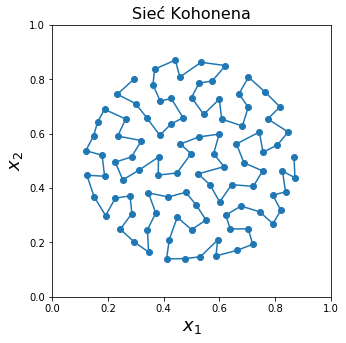

In [53]:
for _ in range(100): # rundy
    eps=eps*.98 # uczenie słabnie z każdą rundą
    de=de*.95   # promień sąsiedztwa też maleje 
    for _ in range(100): # pętla po punktach danych
        p=point()        # tutaj: losowy punkt danych
        dist=[eucl(p,W[k]) for k in range(num)] # tablica euklidesowych odległości
#        print(np.round(dist,3))
        ind_min = np.argmin(dist) # wskaźnik zwycięzcy
#        print(ind_min)
        for k in range(num): 
            W[k]+=eps*phi(ind_min,k,de)*(p-W[k]) # aktualizacja położeń wszystkich neuronów

fk=plt.figure(figsize=(5,5))
plt.title("Sieć Kohonena",fontsize=16) 
plt.xlim(0,1)
plt.ylim(0,1)
 
plt.scatter(W[:,0],W[:,1])
plt.plot(W[:,0],W[:,1])

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);    

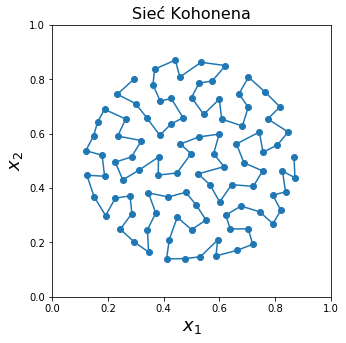

In [54]:
fk

Powyższa wizualizacja rysuje neurony w przestrzeni inputowej, która służy tutaj jako "tło". 

Możemy też patrzeć na odwzorowanie z "punktu widzenia" neuronów:

In [55]:
for i in range(num):
    print(" ",i,np.round(W[i,0],3),np.round(W[i,1],3),end=' ')
    if i>0:
        print(np.round(np.sqrt(eucl(W[i],W[i-1])),3))
    else:
        print()
        
# N -> D  - nasza funkcja       
        
# i   x   y    odległość od poprzedniego

  0 0.293 0.801 
  1 0.234 0.745 0.081
  2 0.3 0.711 0.074
  3 0.34 0.658 0.066
  4 0.386 0.594 0.079
  5 0.426 0.635 0.057
  6 0.469 0.659 0.049
  7 0.427 0.73 0.083
  8 0.388 0.719 0.04
  9 0.362 0.78 0.066
  10 0.367 0.837 0.058
  11 0.442 0.871 0.082
  12 0.458 0.808 0.064
  13 0.534 0.863 0.094
  14 0.622 0.851 0.089
  15 0.574 0.794 0.074
  16 0.527 0.786 0.048
  17 0.5 0.733 0.059
  18 0.544 0.671 0.076
  19 0.599 0.727 0.079
  20 0.608 0.654 0.074
  21 0.682 0.628 0.078
  22 0.703 0.698 0.072
  23 0.67 0.747 0.059
  24 0.704 0.808 0.07
  25 0.763 0.753 0.081
  26 0.817 0.699 0.077
  27 0.773 0.655 0.063
  28 0.846 0.606 0.088
  29 0.808 0.559 0.061
  30 0.756 0.532 0.058
  31 0.743 0.606 0.076
  32 0.661 0.562 0.093
  33 0.688 0.493 0.075
  34 0.755 0.463 0.074
  35 0.721 0.406 0.066
  36 0.644 0.413 0.078
  37 0.601 0.349 0.077
  38 0.565 0.413 0.073
  39 0.523 0.452 0.058
  40 0.616 0.479 0.097
  41 0.579 0.527 0.061
  42 0.599 0.599 0.075
  43 0.527 0.588 0.073
  44 0.46 0.5

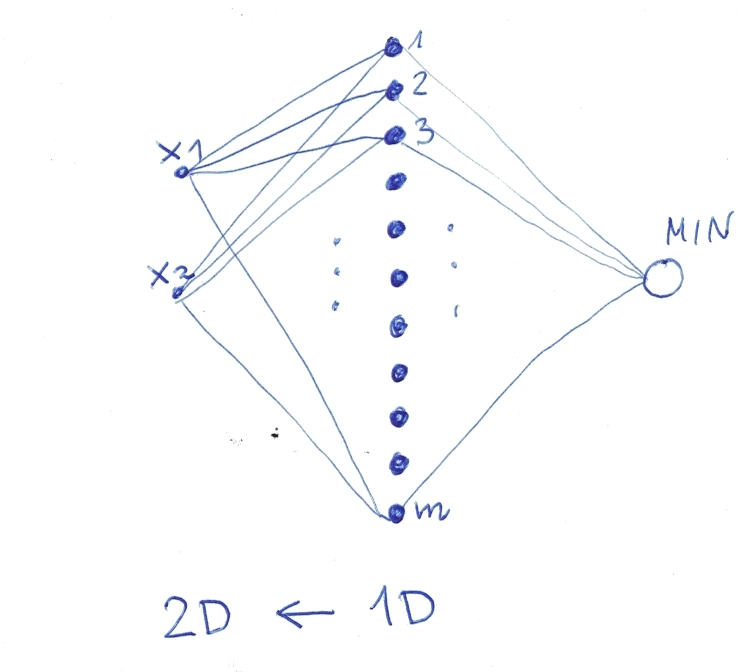

In [56]:
Image(filename="images/Koh21.jpg",width=400)

## Ważne uwagi:

- **Redukcja wymiaru**! Uzyskujemy sytuację, w której przestrzeń danych o wymiarze $n$ (tutaj $n=2$) jest "próbkowana" przez dyskretny zbiór neuronów o wskaźnikack $k$-wymiarowych (tutaj $k=1 < n$). 

- Efektem działania algorytmu jest utworzenie sieci, w której dany neuron "koncentruje się" na danych ze swojej okolicy. W ogólnym (niejednorodnym) przypadku neurony wypełniają gęściej ten obszar, gdzie jest więcej danych, bo punkty danych "przyciągają" neurony. 

- Linie na powyższym rysunku są "by prowadzić oko" po kolejnych neuronach $1,2,...,m$, nie oznaczają żadnego połaczenia (!)

- Widzimy podobne zachowanie do konstrukcji tzw. krzywej Peano - równomiernego wypełnienia obszaru danych linią. 

- Odległości miedzy kolejnymi neuronami są podobne, zob. tabelę powyżej.

- Nie może być przecięć linii (!), bo byłoby to sprzeczne z warunkiem topologicznym. Bliskie punkty z przestrzeni danych mogłyby wówczas odpowiadać odległym neuronom.

- Dobranie parametrów $\delta$ i $\varepsilon$ i ich zmniejszanie w kolejnch rundach jest "doświadczalne" i nietrywialne.


- Fakt, że można uzyskać zachowanie topologii tak prostym przepisem, jak strategia "zwycięzca bierze większość" w uczeniu nienadzorowanym, jest fascynujący.

### Puścić powyższe z innymi parametrami oraz dla innego obszaru danych

Przybliżona reprezentacja danych dwuwymiarowych z pomocą jednowymiarowej linii neuronów.

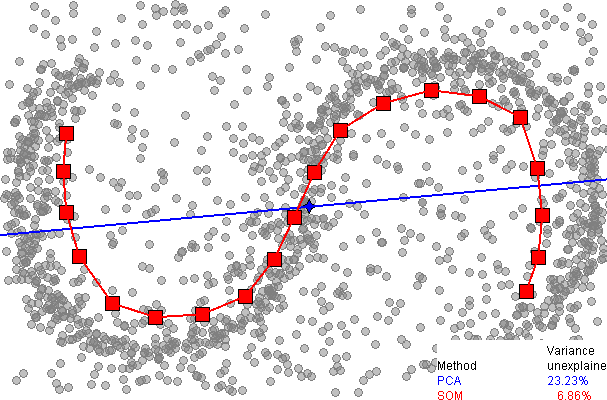

In [57]:
Image(filename="images/SOMsPCA.png",width=320)

# Podstawowa funkcjonaność SOM:

1. Uczenie (w nienadzorowany sposób)
2. Używanie jako klasyfikatora

## Inny przykład: mapa kolorów

Teraz przykład odwzorowania dwuwymiarowej siatki neuronów w 3-wymiarowe dane

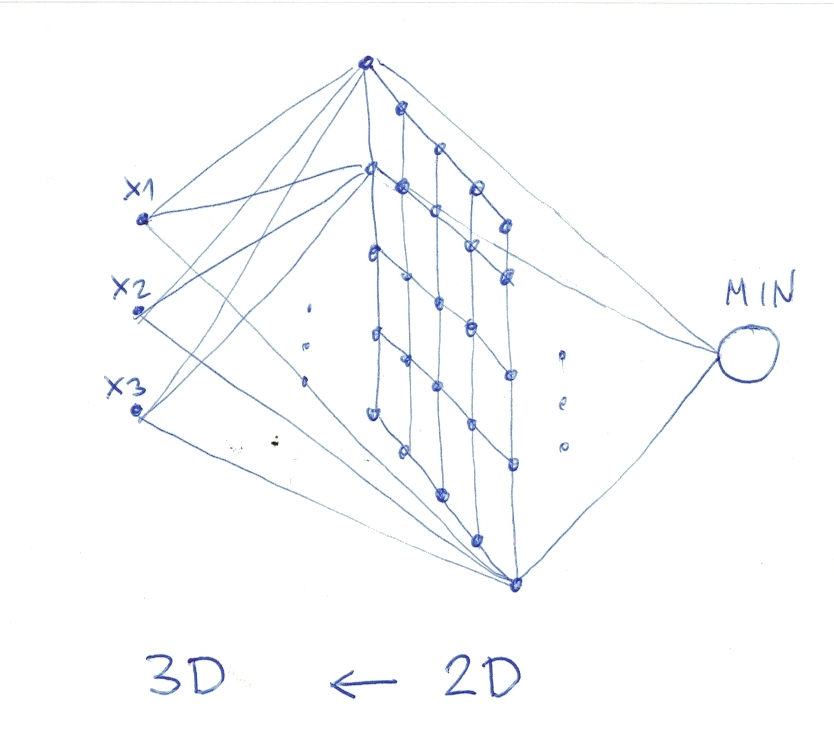

In [58]:
Image(filename="images/Koh32.jpg",width=430)

In [59]:
def dist3(p1,p2): # kwadrat odległości euklidesowej w trzech wymiarach
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2

In [60]:
def phi2(ix,iy,kx,ky,d): # funkcja sprzężenia sąsiadów w dwóch wymiarach
    return np.exp(-((ix-kx)**2+(iy-ky)**2)/(d**2)) # dwuwymiarowa funkcja Gaussa

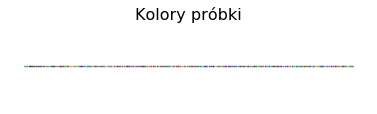

In [61]:
ns=500  # zrób dla 3, 4, 5, 30, 500
# losowa próbka ns kolorów

samp=[[random.random(),random.random(),random.random()] for _ in range(ns)]

#samp=[[random.random(),0,0] for _ in range(ns)] # jeden wymiar/kolor


# próbka RGB
# samp=[[1,0,0],[0,1,0],[0,0,1]]

plt.figure(figsize=(6.5,1.5))
plt.title("Kolory próbki",fontsize=16) 

plt.axis('off')

for i in range(ns):
    plt.scatter(i/ns,0,color=samp[i], s=50000/ns**2); # skaluje współrzędne do [0,1]

In [62]:
np.round(samp,3)

array([[0.273, 0.626, 0.241],
       [0.665, 0.955, 0.324],
       [0.137, 0.607, 0.982],
       ...,
       [0.384, 0.071, 0.914],
       [0.807, 0.148, 0.347],
       [0.849, 0.828, 0.28 ]])

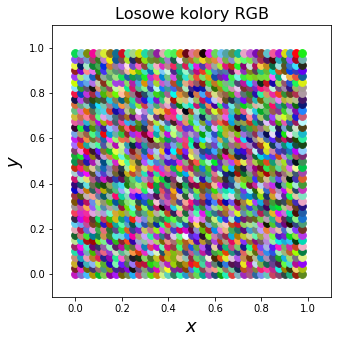

In [63]:
size=40  # tablica neuronów size x size (40 x 40)

tab=np.zeros((size,size,3)) # tworzenie tablicy  

for i in range(size):      # wskaźnik w jednym kierunky
    for j in range(size):  # wskaźnik w drugim kierunku
        for k in range(3): # 3 składowe RGB
#        for k in range(1): # jeden wymiar/kolor
            tab[i][j][k]=random.random() # losowa inicjalizacja każdej składowej koloru

plt.figure(figsize=(5,5))
plt.title("Losowe kolory RGB",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(size):
    for j in range(size):
        plt.scatter(i/size,j/size,color=tab[i][j], s=60) # skaluje współrzędne do [0,1]

plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18);

In [64]:
eps=.5   # początkowa szybkość uczenia (0.5)
de = 10  # początkowy promień sąsiedztwa (25 dla małych próbek, 10 dla większych)
rep= 1   # powtórzenia po próbce bez zmiany eps i de (4,1)

### Wykonuj najpierw krok po kroku

0.45219103750440215 6.648326359915008


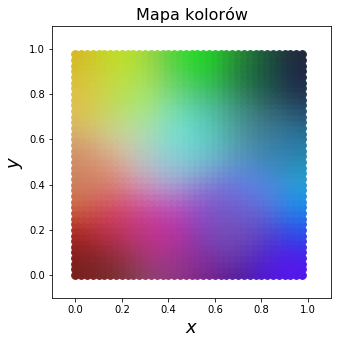

In [65]:
for _ in range(10):  # rundy z uaktualnieniem eps i de (100)
    eps=eps*.99      # uczenie słabnie z każdą rundą
    de=de*.96        # promień sąsiedztwa też maleje 
    for _ in range(rep):    # powtórz bez uaktualniania eps i de
        for s in range(ns): # pętla po punktach danych        
#            p=[random.random(),random.random(),random.random()] # losowy kolor RGB
            p=samp[s] # punkt próbki
            dist=[[dist3(p,tab[i][j]) for j in range(size)] for i in range(size)] 
                # tablica kwadratów euklidesowych odległości od p dla wsyzstkich neuronów
            ind_min = np.argmin(dist) # wskaźnik zwycięzcy
            ind_x=ind_min//size       # tak trzeba wyłowić wskaźnik dwuwymiarowy (!)
            ind_y=ind_min%size
#            print(dist)
#            print(ind_x, ind_y, dist[ind_x][ind_y], tab[ind_x][ind_y])

            for j in range(size): 
                for i in range(size):
                    tab[i][j]+=eps*phi2(ind_x,ind_y,i,j,de)*(p-tab[i][j]) 
                      # aktualizacja wg strategii "zwycięzca bierze wiekszość"
                        
                        
fig0=plt.figure(figsize=(5,5))
plt.title("Mapa kolorów",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(size):
    for j in range(size):
        plt.scatter(i/size,j/size,color=tab[i][j], s=60) # skalujemy współrzędne do [0,1]

plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18);

print(eps,de) # końcowe wartości parametrów

### Komentarze

- Algorytm dzieli dane na klastry w tym sensie, że bliskie dane są mapowane na bliskie neurony.

- Końcowy wynik nie jest jednoznaczny, tzn. puszczenie algorytmu z inną inicjalizacją wag daje inny podział, równie "dobry".

- Obszary dla poszczególnych kolorów próbki mają porównywalną powierzchnię. Ogólnie, obszar jest proporcjonalny do liczebności próbki.

- Aby uzyskać ostrzejsze granice między obszarami, de musi maleć szybciej niż eps. Wówczas w końcowej fazie uczenia proces adaptacji neuronów zachodzi dla małych promieni sąsiedztwa.

- Nie ma sensu rozważać przypadku, gdy wymiar sieci neuronów jest większy od wymiaru danych **(puść ten przykład)**.


### Najpierw pokaż macierz U poniżej. Potem wróć i puść dla różnych wartości de oraz dla różnych liczebności próbki, a także dla próbki nieskończonej oraz dla jednego koloru.

## Macierz U (unified distance matrix)

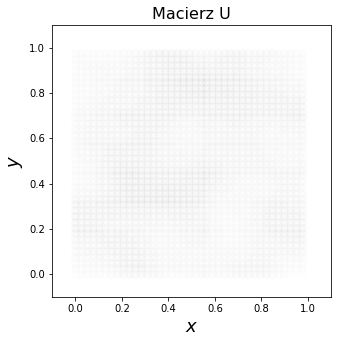

In [66]:
siz=size-1 

ta=np.zeros((siz,siz))

sc=0.25

for i in range(siz):
    for j in range(siz):
        ta[i][j]=sc*np.sqrt(dist3(tab[i][j],tab[i][j+1])+
                            dist3(tab[i][j+1],tab[i+1][j+1])+
                            dist3(tab[i+1][j+1],tab[i+1][j])+
                            dist3(tab[i+1][j],tab[i][j]))
        # suma kwadratów odległosci "po plakietce"
plt.figure(figsize=(5,5))
plt.title("Macierz U",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(siz):
    for j in range(siz):
        plt.scatter(i/siz,j/siz,color=[0,0,0,ta[i][j]], s=60) 

plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18);

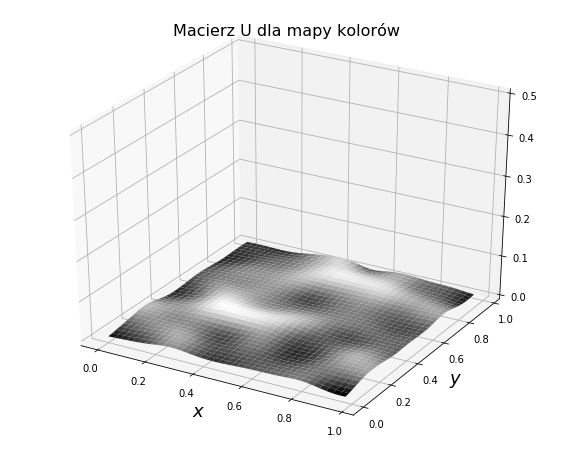

In [67]:
fig = plt.figure(figsize=(10,8))
axes1 = fig.add_subplot(111, projection="3d")
ax = fig.gca(projection='3d')

xx_1 = np.arange(0, 1, 1./siz)
xx_2 = np.arange(0, 1, 1./siz)

x_1, x_2 = np.meshgrid(xx_1, xx_2)

Z=np.array([[ta[i][j] for i in range(siz)] for j in range(siz)])

ax.set_zlim(0,.5)

ax.plot_surface(x_1,x_2, Z, cmap=cm.gray)

# plt.axis('off')
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18);

plt.title("Macierz U dla mapy kolorów",fontsize=16);


# Mapa odległości dla danego (nowego) punktu danych (tj. użycie klasyfikatora)

In [68]:
nd=samp[2]

In [69]:
nd=[1,0,0]

In [70]:
nd=[random.random(),random.random(),random.random()]

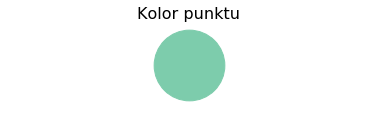

In [71]:
plt.figure(figsize=(6.5,1.5))
plt.title("Kolor punktu",fontsize=16) 

plt.axis('off')
plt.scatter(0,0,color=nd, s=5000); 

### Klasyfikacja punktu wg wcześniej uzyskanej mapy

Współrzędne najbliższego neuronu: ( 0.425 0.725 )
Odległość:  0.059


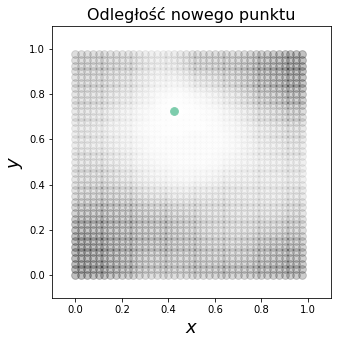

In [72]:
tad=np.zeros((size,size))

for i in range(size):
    for j in range(size):
        tad[i][j]=dist3(nd,tab[i][j])
        

ind_m = np.argmin(tad) # wskaźnik zwycięzcy
in_x=ind_m//size       # tak trzeba wyłowić wskaźnik dwuwymiarowy (!)
in_y=ind_m%size 

da=np.sqrt(tad[in_x][in_y])

print("Współrzędne najbliższego neuronu: (",in_x/size,in_y/size,")")
print("Odległość: ",np.round(da,3))

plt.figure(figsize=(5,5))
plt.title("Odległość nowego punktu",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(size):
    for j in range(size):
        plt.scatter(i/size,j/size,color=[0,0,0,tad[i][j]/3], s=60) 
        
plt.scatter(in_x/size,in_y/size,color=nd, s=60) 

plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18);

### Powtórz dla różnych punktów danych

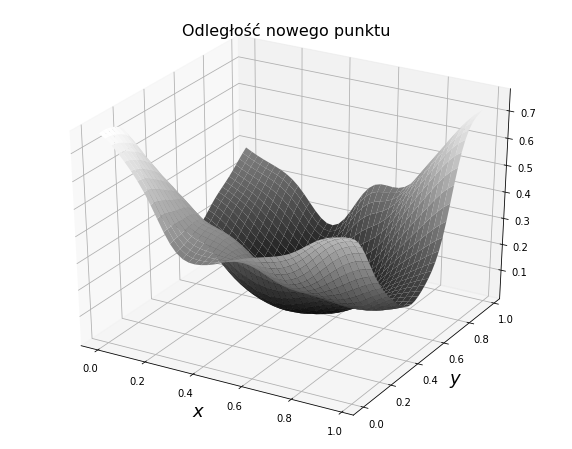

In [73]:
fig = plt.figure(figsize=(10,8))
axes1 = fig.add_subplot(111, projection="3d")
ax = fig.gca(projection='3d')

xx_1 = np.arange(0, 1, 1./size)
xx_2 = np.arange(0, 1, 1./size)

x_1, x_2 = np.meshgrid(xx_1, xx_2)

Z=np.array([[tad[i][j] for i in range(size)] for j in range(size)])

# ax.set_zlim(0,.5)

ax.plot_surface(x_1,x_2, Z, cmap=cm.gray)

# plt.axis('off')
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18);

plt.title("Odległość nowego punktu",fontsize=16);


## Komentarz

Mamy klasyfikator, "przydzielający" położenie w przestrzeni o zredukowanej liczbe wymiarów.

## Mapowanie kolorów w linię: redukcja trzech wymiarów w jeden

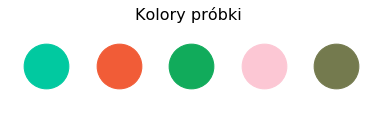

In [131]:
ns=5  # zrób dla 3, 4, 5
# losowa próbka ns kolorów
samp=[[random.random(),random.random(),random.random()] for _ in range(ns)]

# próbka RGB
# samp=[[1,0,0],[0,1,0],[0,0,1]]

fig1=plt.figure(figsize=(6.5,1.5))
plt.title("Kolory próbki",fontsize=16) 

plt.axis('off')

for i in range(ns):
    plt.scatter(i/ns,0,color=samp[i], s=50000/ns**2);

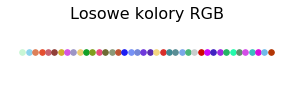

In [132]:
si=40  # tablica si neuronów

tab2=np.zeros((si,3)) # tworzenie tablicy  

for i in range(size):      # wskaźnik w jednym kierunku
    for k in range(3): # 3 składowe RGB
        tab2[i][k]=random.random() # losowa inicjalizacja każdej składowej koloru

plt.figure(figsize=(5,1))
plt.title("Losowe kolory RGB",fontsize=16) 
plt.axis('off')

for i in range(si):
    plt.scatter(i/si,0,color=tab2[i], s=50000/si**2); 

In [133]:
eps=.5    # początkowa szybkość uczenia (0.5)
de = 20   # początkowy promień sąsiedztwa (20)
rep= 1    # powtórzenia po próbce bez zmiany eps i de (4,1)

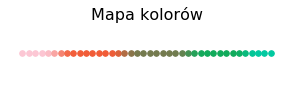

In [135]:
for _ in range(100): # rundy z uaktualnieniem eps i de (100)
    eps=eps*.99      # uczenie słabnie z każdą rundą
    de=de*.96        # promień sąsiedztwa też maleje 
    for _ in range(rep):    # powtórz bez uaktualniania eps i de
        for s in range(ns): # pętla po punktach danych        
#            p=[random.random(),random.random(),random.random()] # losowy kolor RGB
            p=samp[s] # punkt próbki
            dist=[dist3(p,tab2[i]) for i in range(si)] 
                # tablica kwadratów euklidesowych odległości od p dla wszystkich neuronów
            ind_min = np.argmin(dist) # wskaźnik zwycięzcy
         
            for i in range(si):
                tab2[i]+=eps*phi(ind_min,i,de)*(p-tab2[i]) 
                      # aktualizacja wg strategii "zwycięzca bierze wiekszość"

fig2=plt.figure(figsize=(5,1))
plt.title("Mapa kolorów",fontsize=16) 
plt.axis('off')

for i in range(si):
    plt.scatter(i/si,0,color=tab2[i], s=50000/si**2); 

"Gładkie" przejścia między kolorami.

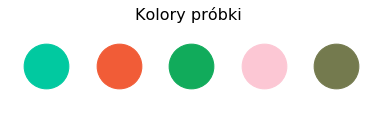

In [136]:
fig1

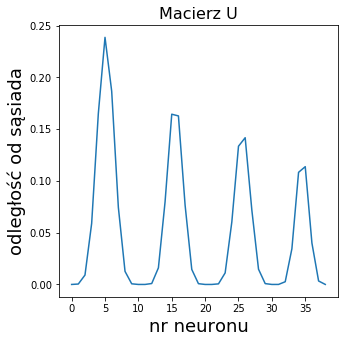

In [137]:
si2=si-1

xr=np.array([i for i in range(si2)])

ta2=np.zeros(si2)

for i in range(si2):
    ta2[i]=np.sqrt(dist3(tab2[i],tab2[i+1]))
        
plt.figure(figsize=(5,5))
plt.title("Macierz U",fontsize=16) 

plt.plot(xr,ta2) 

plt.xlabel('nr neuronu',fontsize=18)
plt.ylabel('odległość od sąsiada',fontsize=18);

Minima odpowiadają poszczególnym kolorom próbki. Wysokość oddzielających maksimów pokazuje, jak bardzo różnią się te kolory.

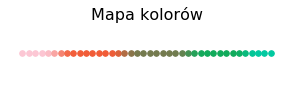

In [138]:
fig2

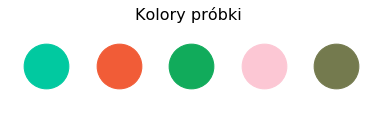

In [139]:
fig1

In [140]:
print(np.round(np.array([[np.sqrt(dist3(samp[i],samp[j])) for i in range(ns)] for j in range(ns)]),3))

[[0.    1.113 0.303 1.005 0.632]
 [1.113 0.    0.945 0.747 0.516]
 [0.303 0.945 0.    1.045 0.435]
 [1.005 0.747 1.045 0.    0.809]
 [0.632 0.516 0.435 0.809 0.   ]]


Najbardziej podobne kolory niekoniecznie sąsiadują. Zachowanie zależy od wartości parametru de.

## Analogiczna analiza dla artykułów w Wikipedii

Redukcja z bardzo wielu wymiarów do dwóch. Poniżej macierz U.

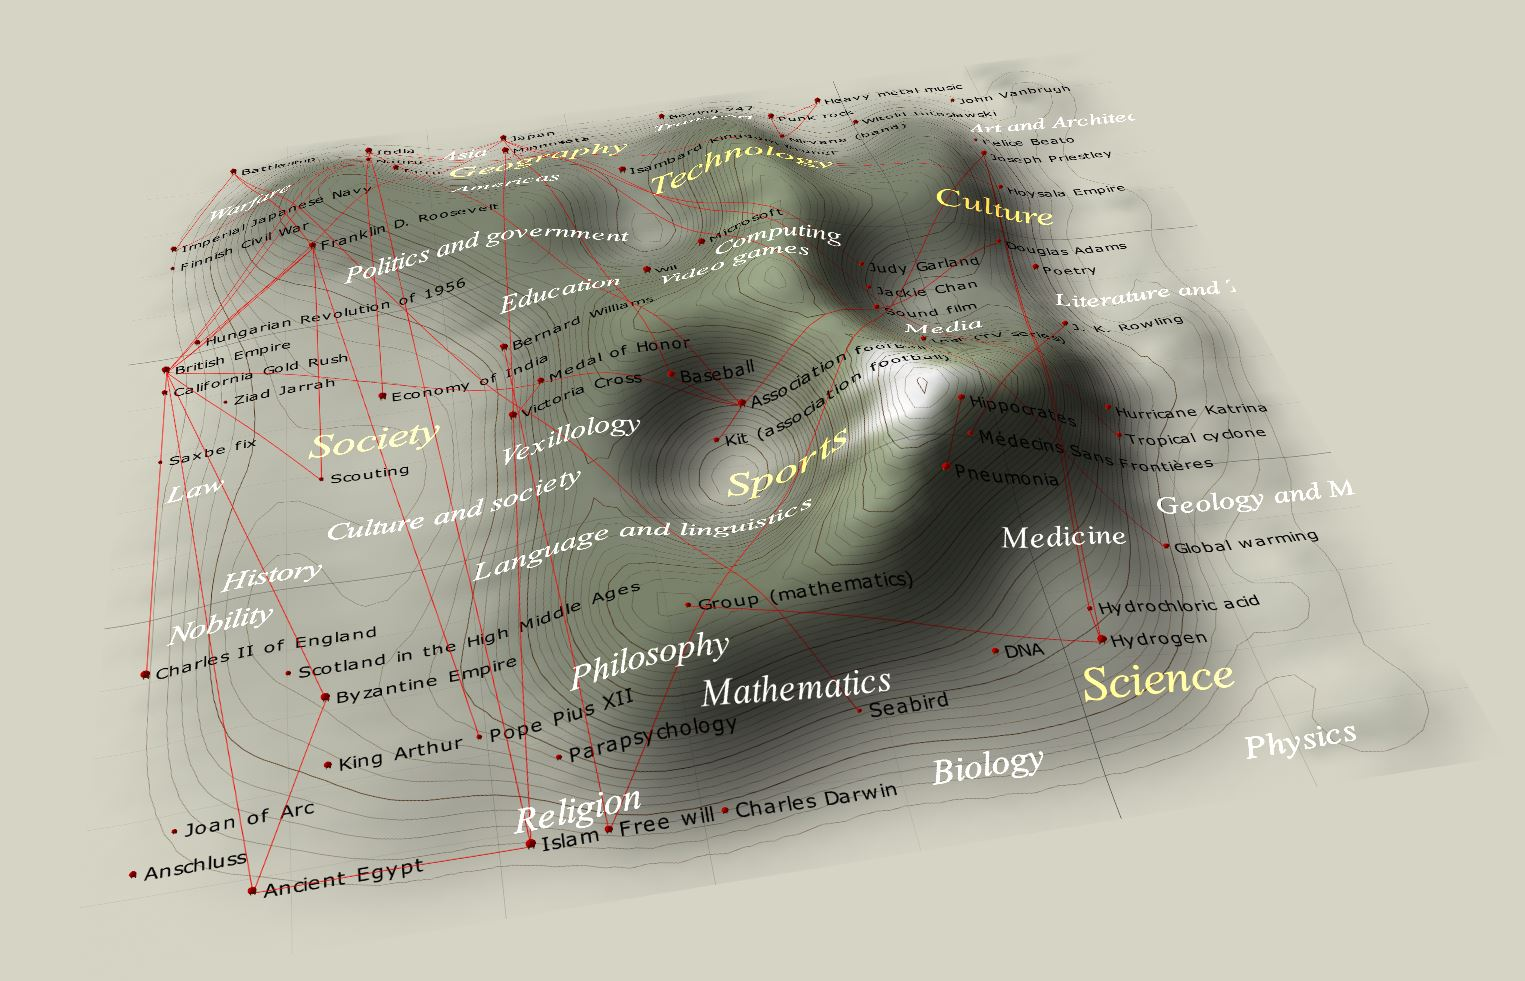

In [82]:
Image(filename="images/Self_oraganizing_map_cartography.jpg",width=620)

[Wikipedia] Cartographical representation of a self-organizing map (U-Matrix) based on Wikipedia featured article data (word frequency). Distance is inversely proportional to similarity. The "mountains" are edges between clusters. The red lines are links between articles.

## Odwzorowanie danych dwuwymiarowych na dwuwymiarową sieć neuronów

Fragment oparty o książkę Raúl Rojas, Neural Networks, a Systematic Introduction.

Ten przypadek jest tematem jednego z projektów, więc nie będziemy dla niego tworzyć programu.
Jest to bardzo ważne koncepcyjnie, gdyż związany jest z postrzeganiem wzrokowym. 

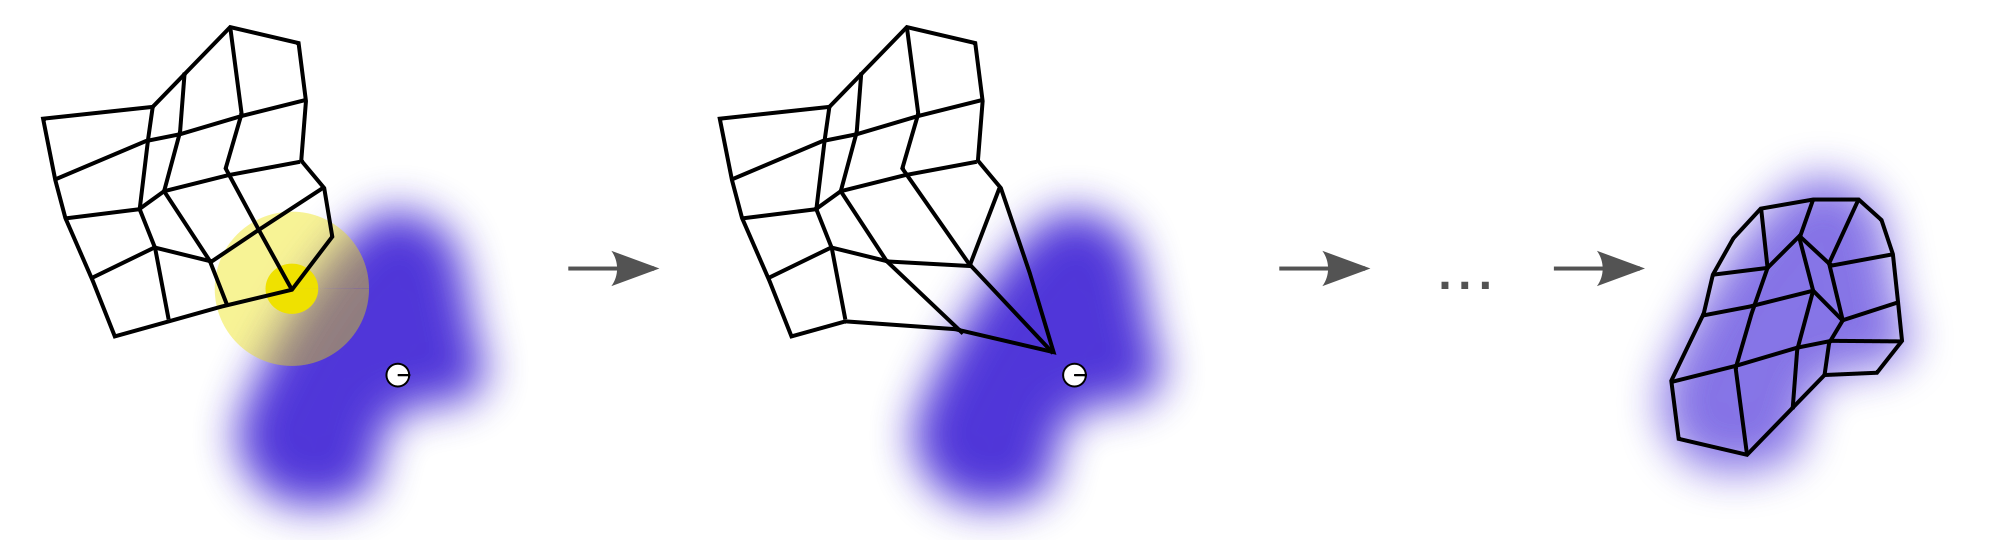

In [83]:
Image(filename="images/koh3.png",width=500)

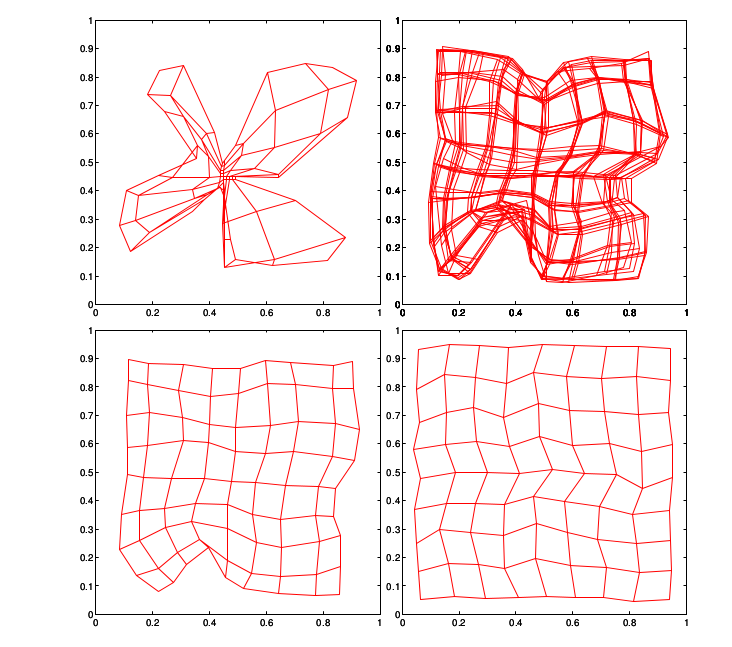

In [84]:
Image(filename="images/koh2.png",width=500)

## Mapowanie siatkówki na obszar wzrokowy kory mózgowej

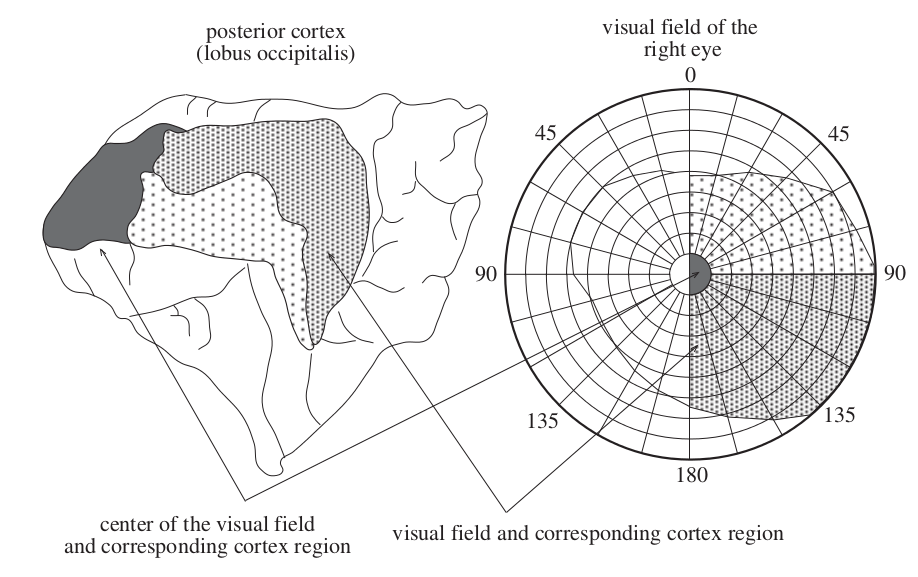

In [85]:
Image(filename="images/map_vis.png",width=650)

## Topologia postrzegania wzrokowego

W tym przypadku zachowanie topologii oznacza, że np. okrąg z siatkówki odwzorowywany jest w pętlę w korze mózgowej. Dygresja o niedoskonałości obrazu i "korekcji poznawczej".

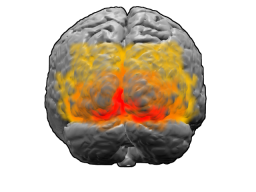

In [86]:
Image(filename="images/Brodmann.png",width=320)

## Bardzo ciekawa strona o obrazowaniu mózgu

HCP - Human Connectome Project http://www.humanconnectomeproject.org/